In [1]:
import shap
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
data = pd.read_csv('../Dataset/dataset_1.csv')

In [3]:
data.head(5)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,3,0,0,1,0,0,0,0,0,0,...,1,2,0,892,0,0,0,0,0,1
1,5,0,1,3,0,3,0,2,0,0,...,1,2,1,9540,1,0,0,0,0,1
2,2,0,0,1,0,0,0,0,0,0,...,1,2,3,589,1,0,0,0,0,0
3,4,0,2,5,0,0,0,0,0,0,...,1,2,0,292,1,0,0,0,0,1
4,2,0,0,0,0,0,0,0,0,0,...,1,2,1,3597,0,1,0,0,0,0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(data[data.columns[:-1]],data[data.columns[-1]],test_size=0.3,random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [5]:
print('-------------------------Using XGBoost---------------------------------\n')

_70_30_xgb_classifier = xgboost.XGBClassifier(max_depth=5, objective='binary:logistic', n_estimators=100)
_70_30_xgb_classifier.fit(X_train, y_train)
_70_30_xgb_predicted_values = _70_30_xgb_classifier.predict(X_test)
print(classification_report(y_test,_70_30_xgb_predicted_values,target_names=['legitimate','phishing']))

print('-------------------------Using RandomForrest----------------------------\n')
_70_30_rf_classifier = RandomForestClassifier(max_depth=5, random_state=42)
_70_30_rf_classifier.fit(X_train, y_train)
_70_30_rf_predicted_values = _70_30_rf_classifier.predict(X_test)
print(classification_report(X_test,_70_30_rf_predicted_values,target_names=['legitimate','phishing']))

-------------------------Using XGBoost---------------------------------

              precision    recall  f1-score   support

  legitimate       0.98      0.97      0.97     17449
    phishing       0.95      0.95      0.95      9146

    accuracy                           0.97     26595
   macro avg       0.96      0.96      0.96     26595
weighted avg       0.97      0.97      0.97     26595

-------------------------Using RandomForrest----------------------------



ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 1. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [31]:
k_folds = StratifiedKFold(n_splits = 5)

scores = cross_val_score(_70_30_xgb_classifier, X_train, y_train, cv = k_folds) 

In [32]:
print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.96486987 0.96567561 0.96768735 0.96970185 0.97018533]
Average CV Score:  0.9676240041017913
Number of CV Scores used in Average:  5


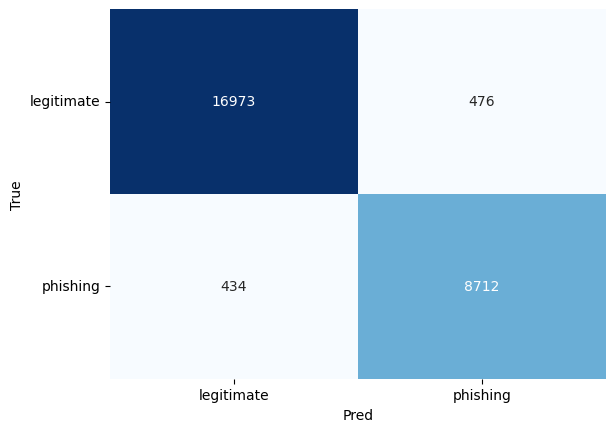

In [6]:
import seaborn as sn

## Plot confusion matrix
unique_classes = ['legitimate','phishing']
cm = confusion_matrix(y_test,_70_30_xgb_predicted_values)
fig, ax = plt.subplots()
sn.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=unique_classes,
       yticklabels=unique_classes)
plt.yticks(rotation=0)
plt.show()

In [7]:
# compute SHAP values for the best model (70:30 split xgboot)
explainer = shap.TreeExplainer(_70_30_xgb_classifier)
shap_values = explainer(X_test)

In [18]:
shap_values.feature_names = data.columns[:-1]

In [8]:
print(np.shape(shap_values))

(26595, 111)


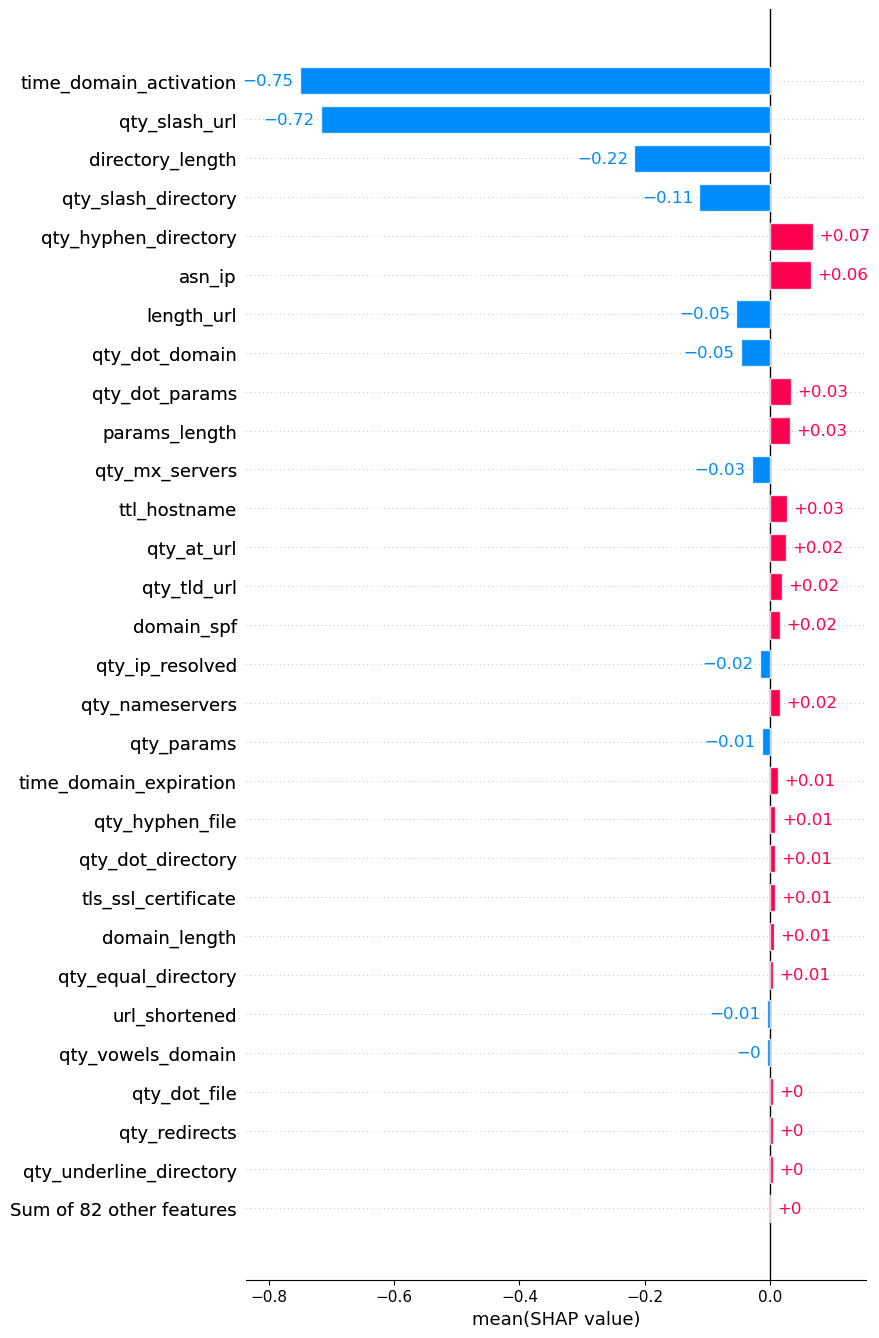

In [19]:
shap.plots.bar(shap_values.mean(0), max_display=30)

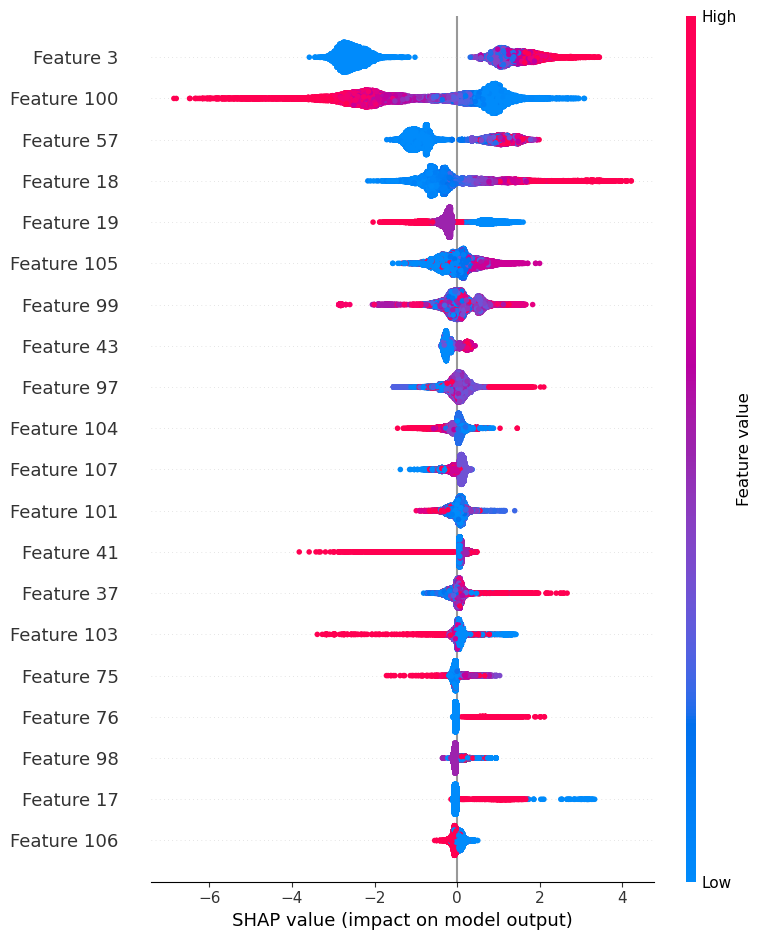

In [10]:
shap.summary_plot(shap_values, X_test)

0


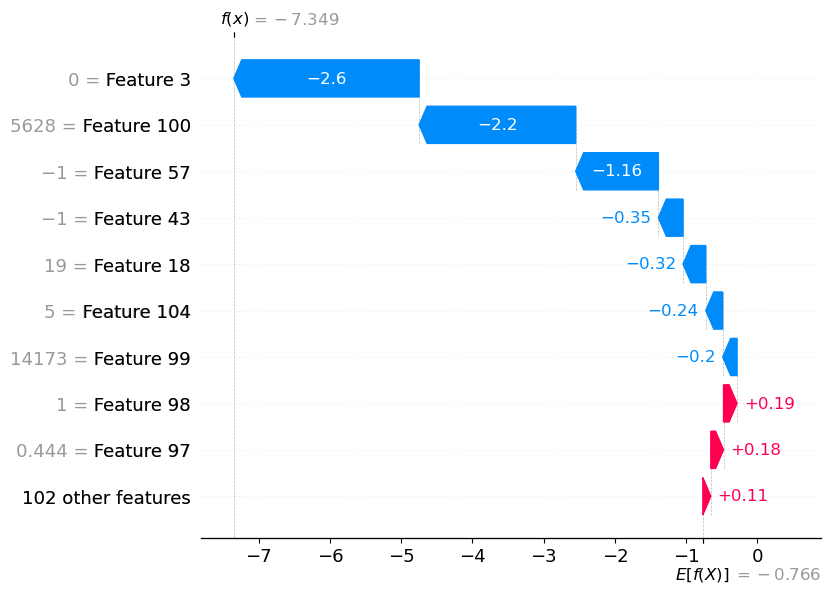

In [11]:
print(y_test[2000])
shap.plots.waterfall(shap_values[2000,:])

1 7


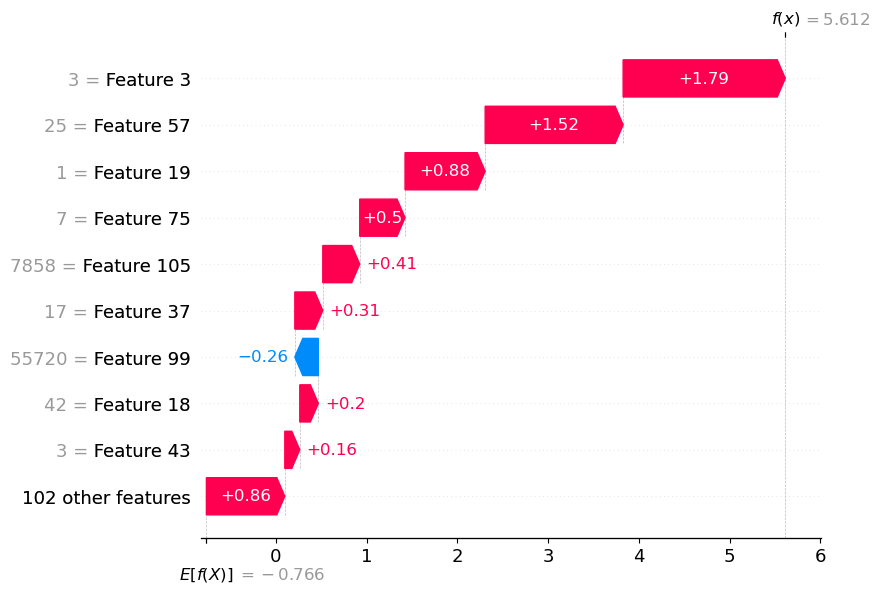

In [12]:
for i in range(len(y_test)):
    if y_test[i]==1:
        print(y_test[i],i)
        break
shap.plots.waterfall(shap_values[i,:])

In [13]:
tp_instances = np.where((y_test == 1) & (_70_30_xgb_predicted_values == 1))[0]
tn_instances = np.where((y_test == 0) & (_70_30_xgb_predicted_values == 0))[0]
fp_instances = np.where((y_test == 0) & (_70_30_xgb_predicted_values == 1))[0]
fn_instances = np.where((y_test == 1) & (_70_30_xgb_predicted_values == 0))[0]

In [14]:
explainer_class_tp = shap.Explainer(_70_30_xgb_classifier, X_test[tp_instances])
shap_values_class_tp = explainer_class_tp(X_test[tp_instances])

explainer_class_tn = shap.Explainer(_70_30_xgb_classifier, X_test[tn_instances])
shap_values_class_tn = explainer_class_tn(X_test[tn_instances])

 99%|===================| 16737/16973 [00:32<00:00]        

In [15]:
shap_values_class_tp.feature_names = data.columns[:-1]
shap_values_class_tn.feature_names = data.columns[:-1]

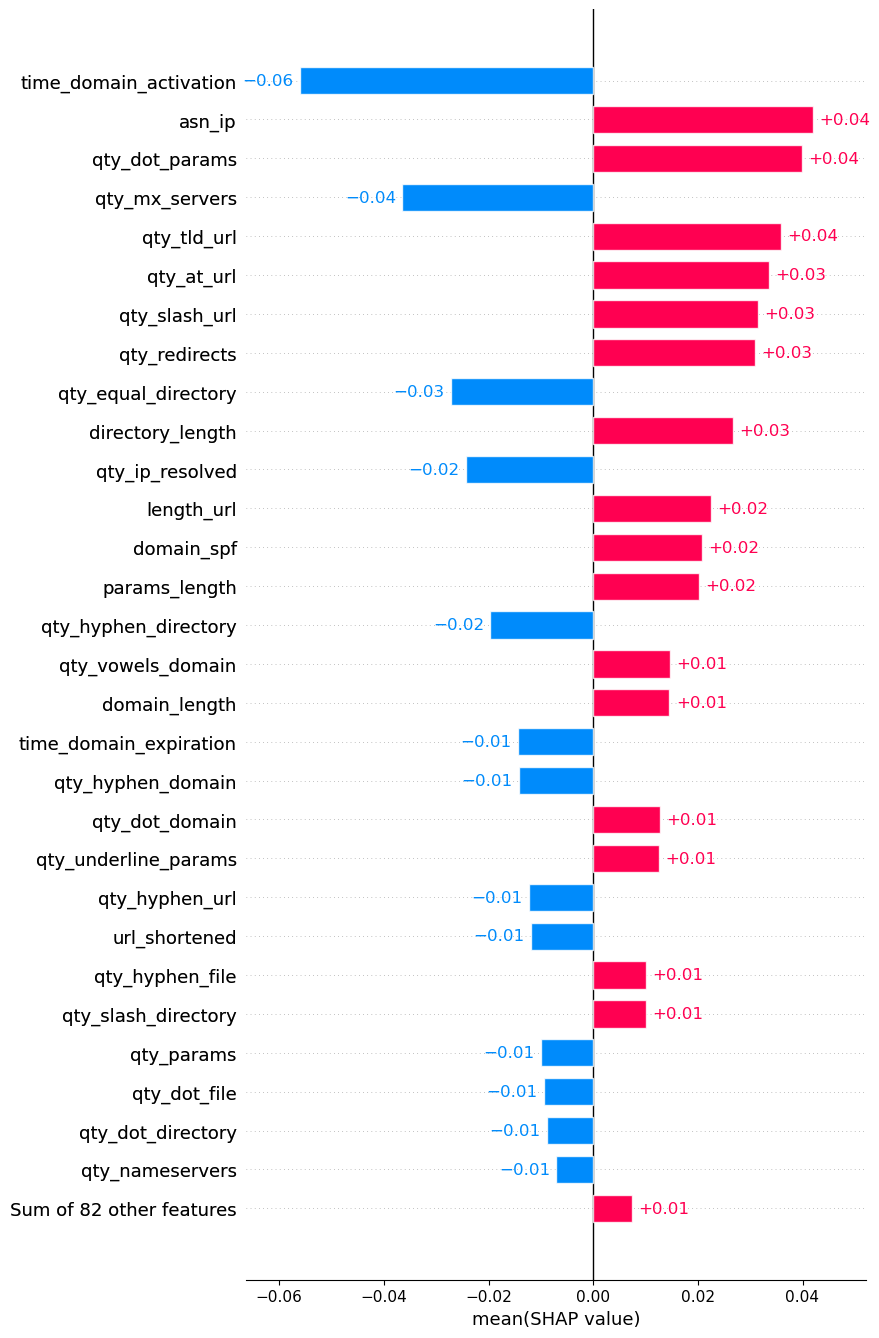

In [17]:
shap.plots.bar(shap_values_class_tp.mean(0), max_display=30)

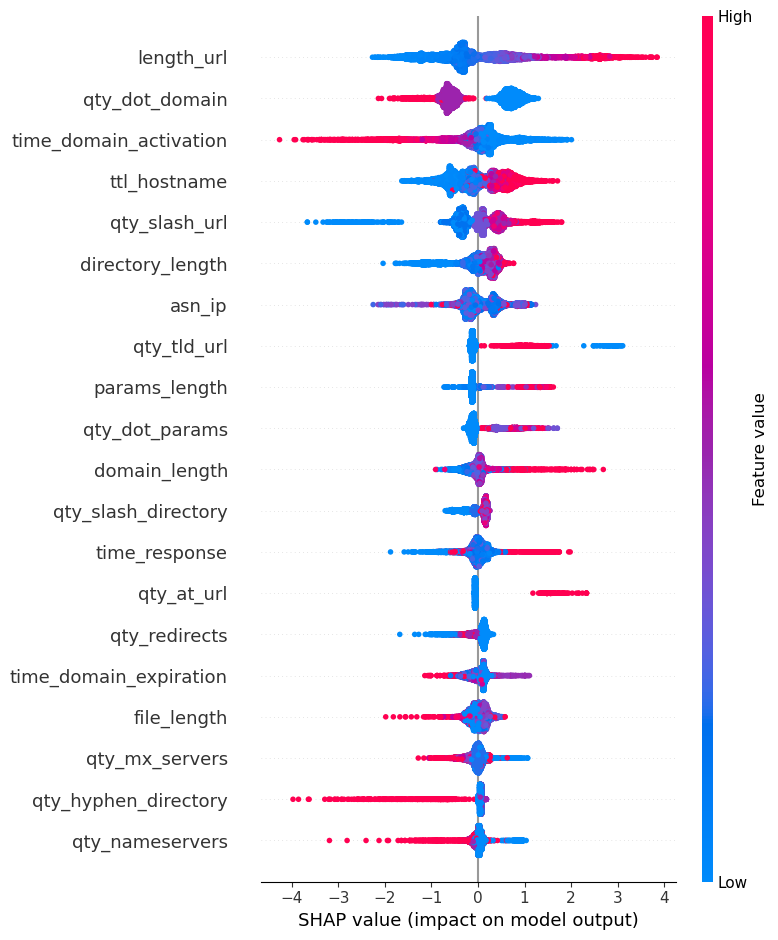

In [20]:
shap.summary_plot(shap_values_class_tp)

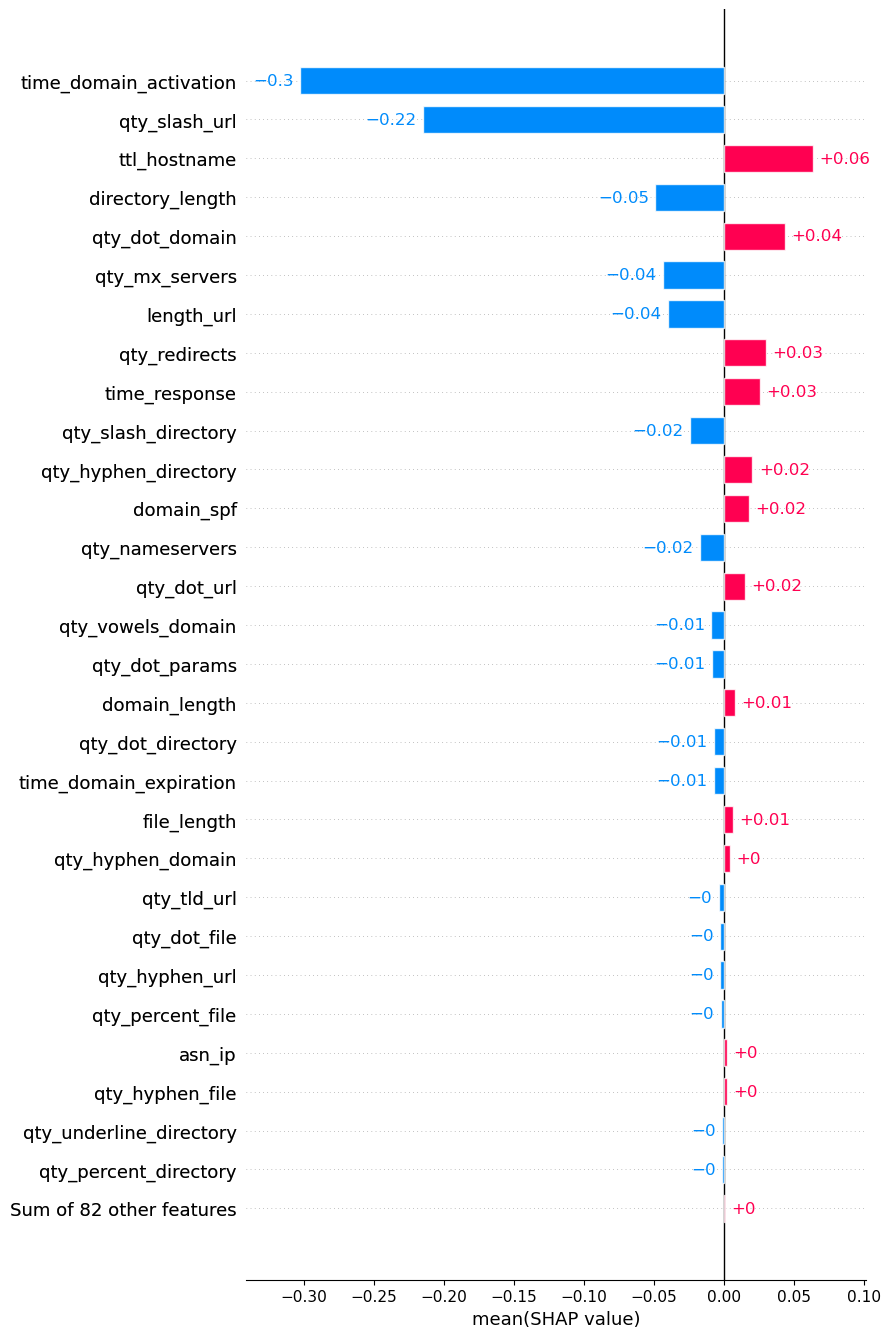

In [22]:
shap.plots.bar(shap_values_class_tn.mean(0), max_display=30)

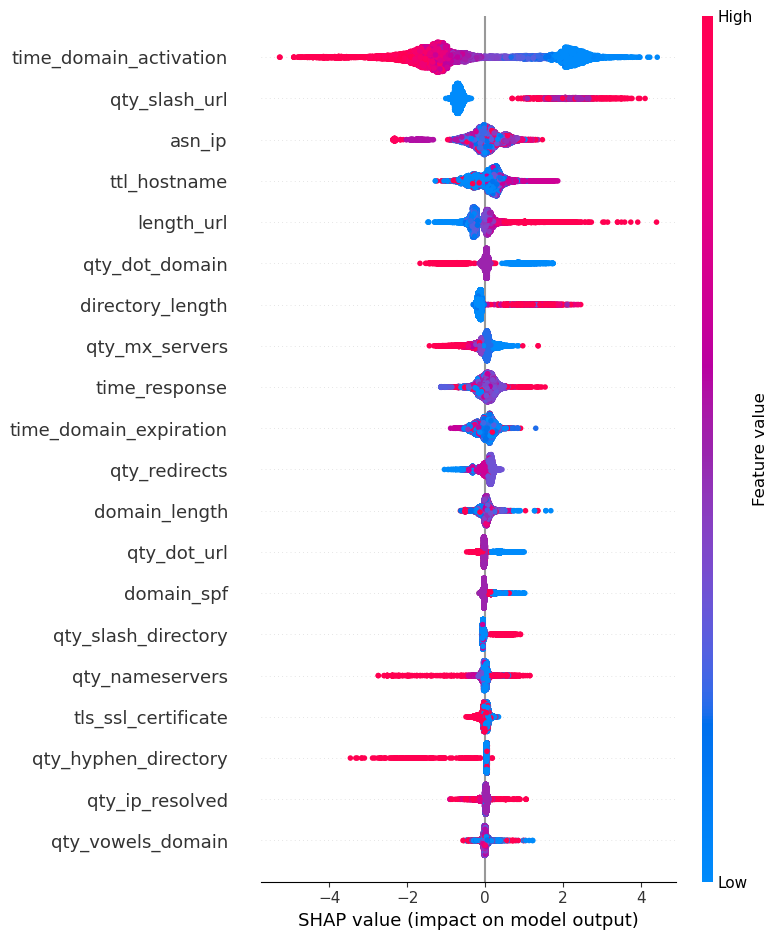

In [23]:
shap.summary_plot(shap_values_class_tn)

In [24]:
explainer_class_fp = shap.Explainer(_70_30_xgb_classifier, X_test[fp_instances])
shap_values_class_fp = explainer_class_fp(X_test[fp_instances])

explainer_class_fn = shap.Explainer(_70_30_xgb_classifier, X_test[fn_instances])
shap_values_class_fn = explainer_class_fn(X_test[fn_instances])

In [25]:
shap_values_class_fp.feature_names = data.columns
shap_values_class_fn.feature_names = data.columns

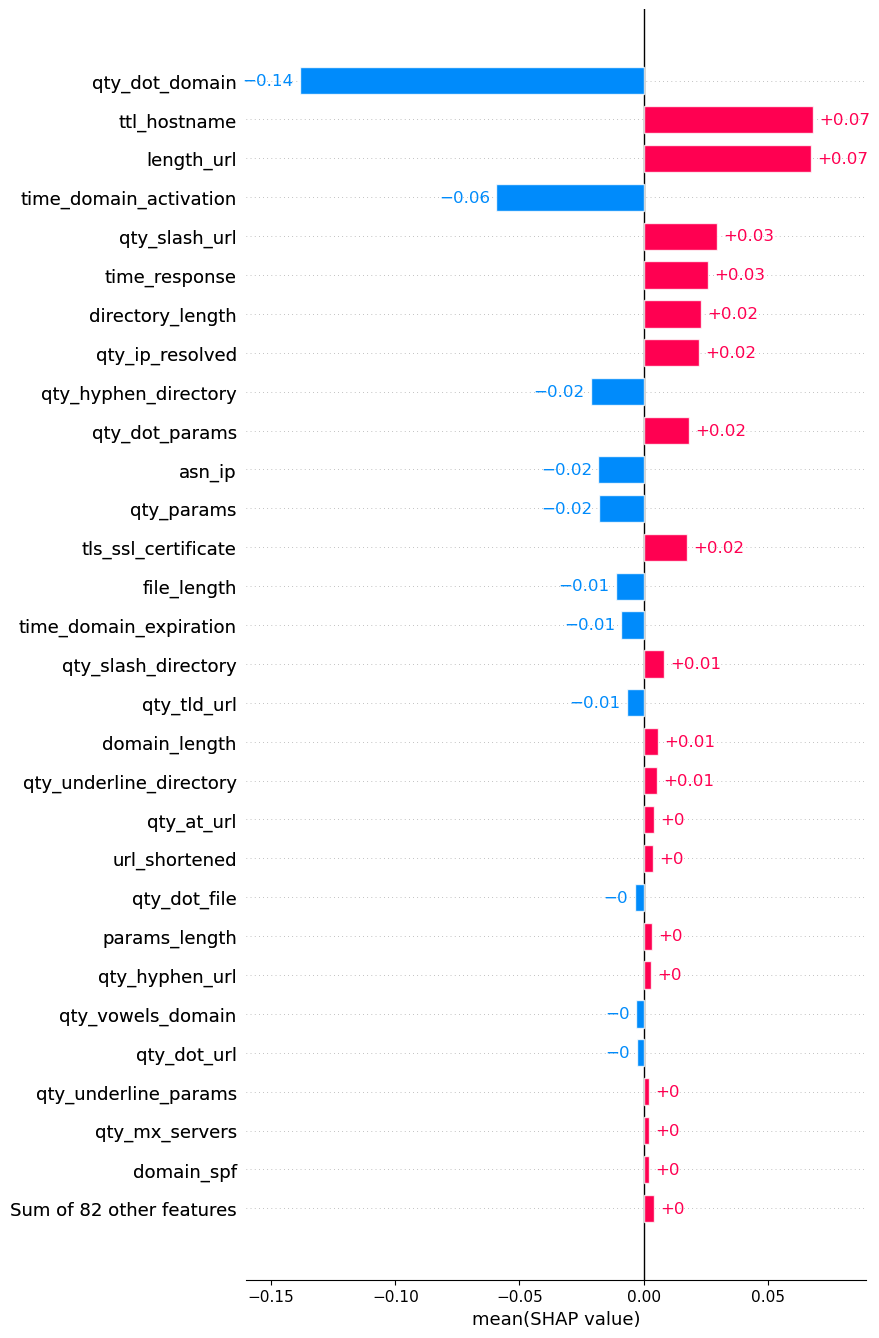

In [26]:
shap.plots.bar(shap_values_class_fp.mean(0), max_display=30)

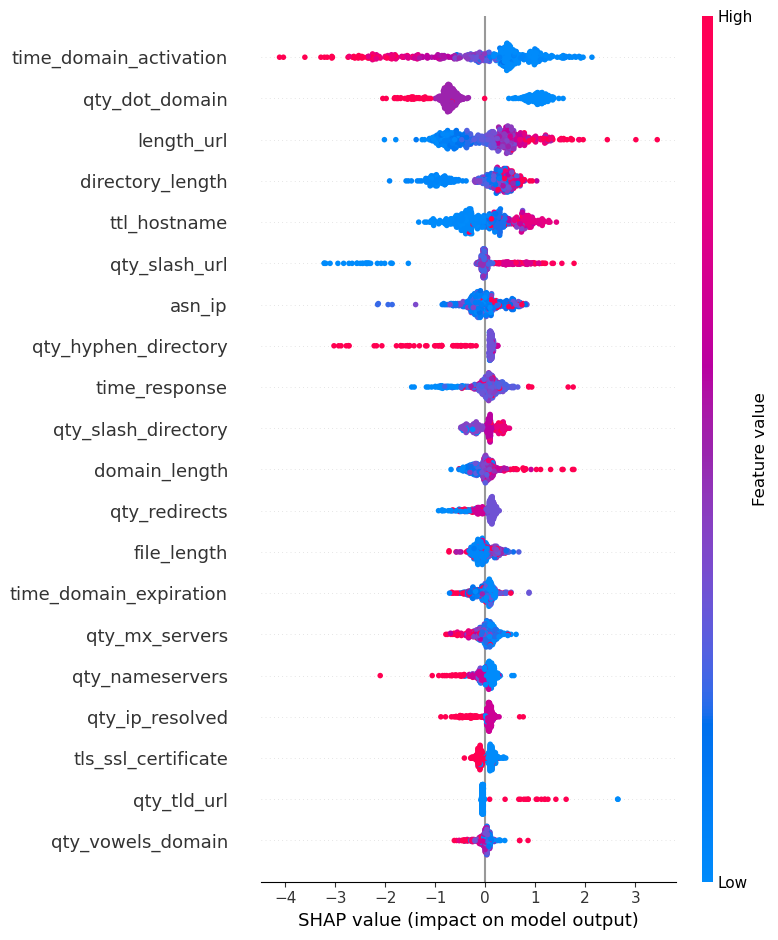

In [27]:
shap.summary_plot(shap_values_class_fp)

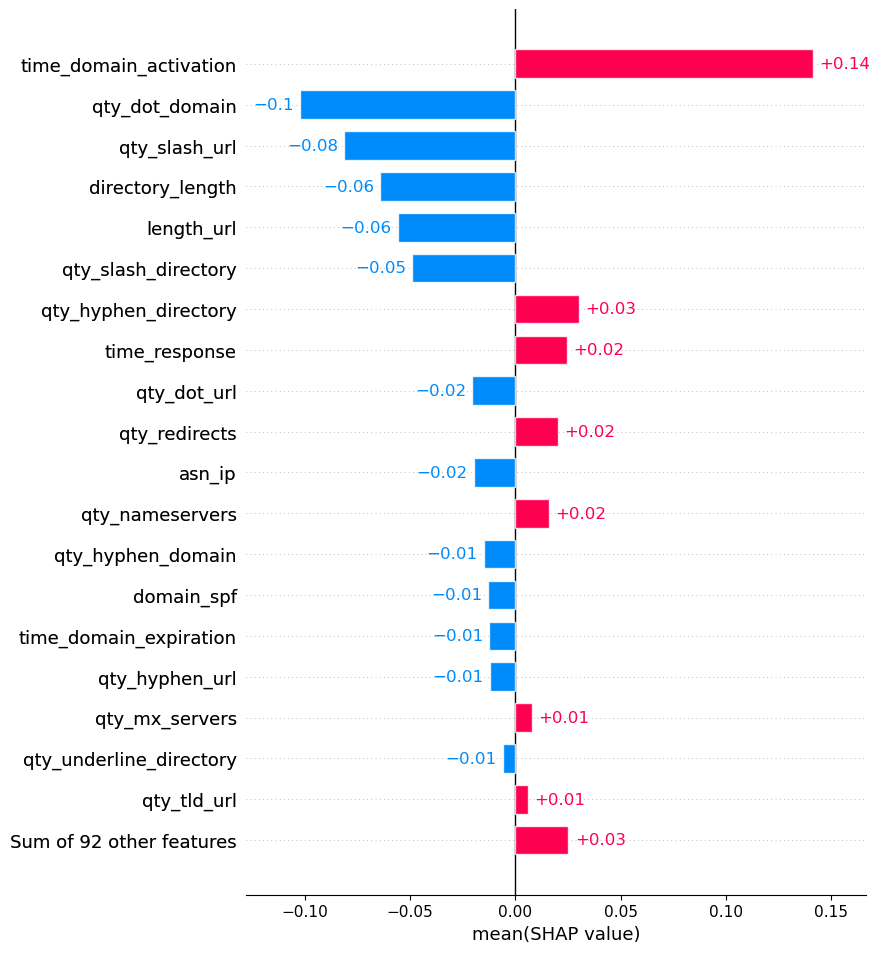

In [28]:
shap.plots.bar(shap_values_class_fn.mean(0), max_display=20)

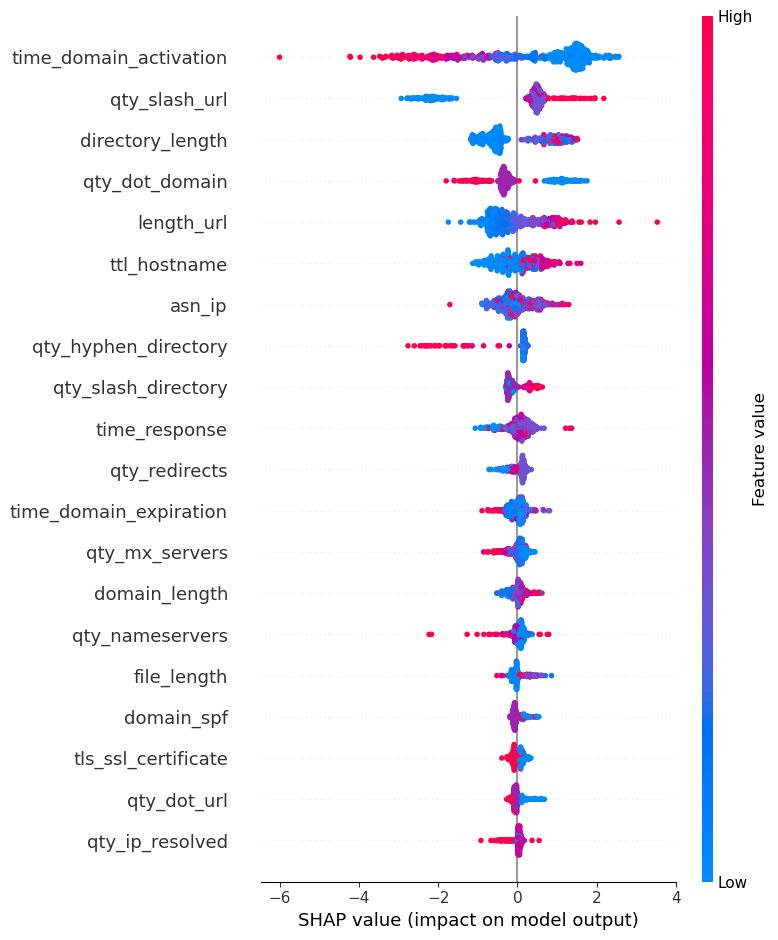

In [29]:
shap.summary_plot(shap_values_class_fn)